# Stage 07: Outlier Analysis

This notebook demonstrates outlier detection and analysis for the Portfolio Risk Management System.

## Objectives
- Detect outliers using multiple statistical methods
- Analyze impact of outliers on portfolio metrics
- Implement robust outlier handling strategies
- Visualize outlier patterns and distributions

In [1]:
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import utils
import outliers
from dotenv import load_dotenv

# Load environment variables
load_dotenv('../.env')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Outlier Analysis Setup Complete")

📊 Outlier Analysis Setup Complete


## 1. Load Portfolio Data

In [2]:
# Load existing portfolio data or fetch fresh data
portfolio_symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "META"]

print(f"Fetching data for portfolio: {portfolio_symbols}")

# Fetch portfolio data
portfolio_data = utils.fetch_multiple_stocks(
    symbols=portfolio_symbols,
    prefer_alphavantage=False,  # Use yfinance for reliability
    period="1y"  # Get more data for better outlier analysis
)

if not portfolio_data.empty:
    print(f"✅ Portfolio data loaded successfully")
    print(f"Shape: {portfolio_data.shape}")
    print(f"Date range: {portfolio_data['date'].min()} to {portfolio_data['date'].max()}")
    print(f"Symbols: {portfolio_data['symbol'].unique()}")
    
    # Calculate daily returns
    portfolio_data = portfolio_data.sort_values(['symbol', 'date'])
    portfolio_data['daily_return'] = portfolio_data.groupby('symbol')['close'].pct_change()
    portfolio_data['log_return'] = np.log(portfolio_data['close'] / portfolio_data.groupby('symbol')['close'].shift(1))
    
    # Remove NaN values
    portfolio_data = portfolio_data.dropna()
    
    print(f"\n📈 Returns calculated. Final shape: {portfolio_data.shape}")
else:
    print("❌ Failed to load portfolio data")

Fetching data for portfolio: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META']
📈 Using yfinance fallback for AAPL
📈 Fetching AAPL data (period=1y, interval=1d)
✅ Fetched 250 records for AAPL
📈 Using yfinance fallback for MSFT
📈 Fetching MSFT data (period=1y, interval=1d)
✅ Fetched 250 records for MSFT
📈 Using yfinance fallback for GOOGL
📈 Fetching GOOGL data (period=1y, interval=1d)
✅ Fetched 250 records for GOOGL
📈 Using yfinance fallback for AMZN
📈 Fetching AMZN data (period=1y, interval=1d)
✅ Fetched 250 records for AMZN
📈 Using yfinance fallback for TSLA
📈 Fetching TSLA data (period=1y, interval=1d)
✅ Fetched 250 records for TSLA
📈 Using yfinance fallback for NVDA
📈 Fetching NVDA data (period=1y, interval=1d)
✅ Fetched 250 records for NVDA
📈 Using yfinance fallback for META
📈 Fetching META data (period=1y, interval=1d)
✅ Fetched 250 records for META
✅ Combined data for 7 symbols: (1750, 11)
📊 Data sources used: {'yfinance': np.int64(1750)}
✅ Portfolio data loaded successful

## 2. Outlier Detection - IQR Method

In [3]:
if not portfolio_data.empty:
    # Detect outliers using IQR method for daily returns
    print("🔍 Detecting outliers using IQR method...")
    
    outlier_results = {}
    
    for symbol in portfolio_data['symbol'].unique():
        symbol_data = portfolio_data[portfolio_data['symbol'] == symbol].copy()
        
        # Detect outliers in daily returns
        outlier_mask = outliers.detect_outliers_iqr(
            symbol_data, 
            columns=['daily_return'], 
            multiplier=1.5
        )
        
        outlier_count = outlier_mask.sum()
        outlier_percentage = (outlier_count / len(symbol_data)) * 100
        
        outlier_results[symbol] = {
            'count': outlier_count,
            'percentage': outlier_percentage,
            'outlier_data': symbol_data[outlier_mask]
        }
        
        print(f"  {symbol}: {outlier_count} outliers ({outlier_percentage:.2f}%)")
    
    # Create summary DataFrame
    outlier_summary = pd.DataFrame({
        'Symbol': list(outlier_results.keys()),
        'Outlier_Count': [r['count'] for r in outlier_results.values()],
        'Outlier_Percentage': [r['percentage'] for r in outlier_results.values()]
    })
    
    print("\n📊 Outlier Summary:")
    print(outlier_summary)

🔍 Detecting outliers using IQR method...


TypeError: detect_outliers_iqr() got an unexpected keyword argument 'columns'

## 3. Outlier Detection - Z-Score Method

In [4]:
if not portfolio_data.empty:
    print("🔍 Detecting outliers using Z-Score method...")
    
    zscore_results = {}
    
    for symbol in portfolio_data['symbol'].unique():
        symbol_data = portfolio_data[portfolio_data['symbol'] == symbol].copy()
        
        # Detect outliers using Z-score
        outlier_mask = outliers.detect_outliers_zscore(
            symbol_data, 
            columns=['daily_return'], 
            threshold=3.0
        )
        
        outlier_count = outlier_mask.sum()
        outlier_percentage = (outlier_count / len(symbol_data)) * 100
        
        zscore_results[symbol] = {
            'count': outlier_count,
            'percentage': outlier_percentage
        }
        
        print(f"  {symbol}: {outlier_count} outliers ({outlier_percentage:.2f}%)")
    
    # Compare IQR vs Z-Score methods
    comparison_df = pd.DataFrame({
        'Symbol': list(outlier_results.keys()),
        'IQR_Count': [r['count'] for r in outlier_results.values()],
        'ZScore_Count': [r['count'] for r in zscore_results.values()],
        'IQR_Percentage': [r['percentage'] for r in outlier_results.values()],
        'ZScore_Percentage': [r['percentage'] for r in zscore_results.values()]
    })
    
    print("\n📊 Method Comparison:")
    print(comparison_df)

🔍 Detecting outliers using Z-Score method...


TypeError: detect_outliers_zscore() got an unexpected keyword argument 'columns'

## 4. Visualize Outliers

NameError: name 'comparison_df' is not defined

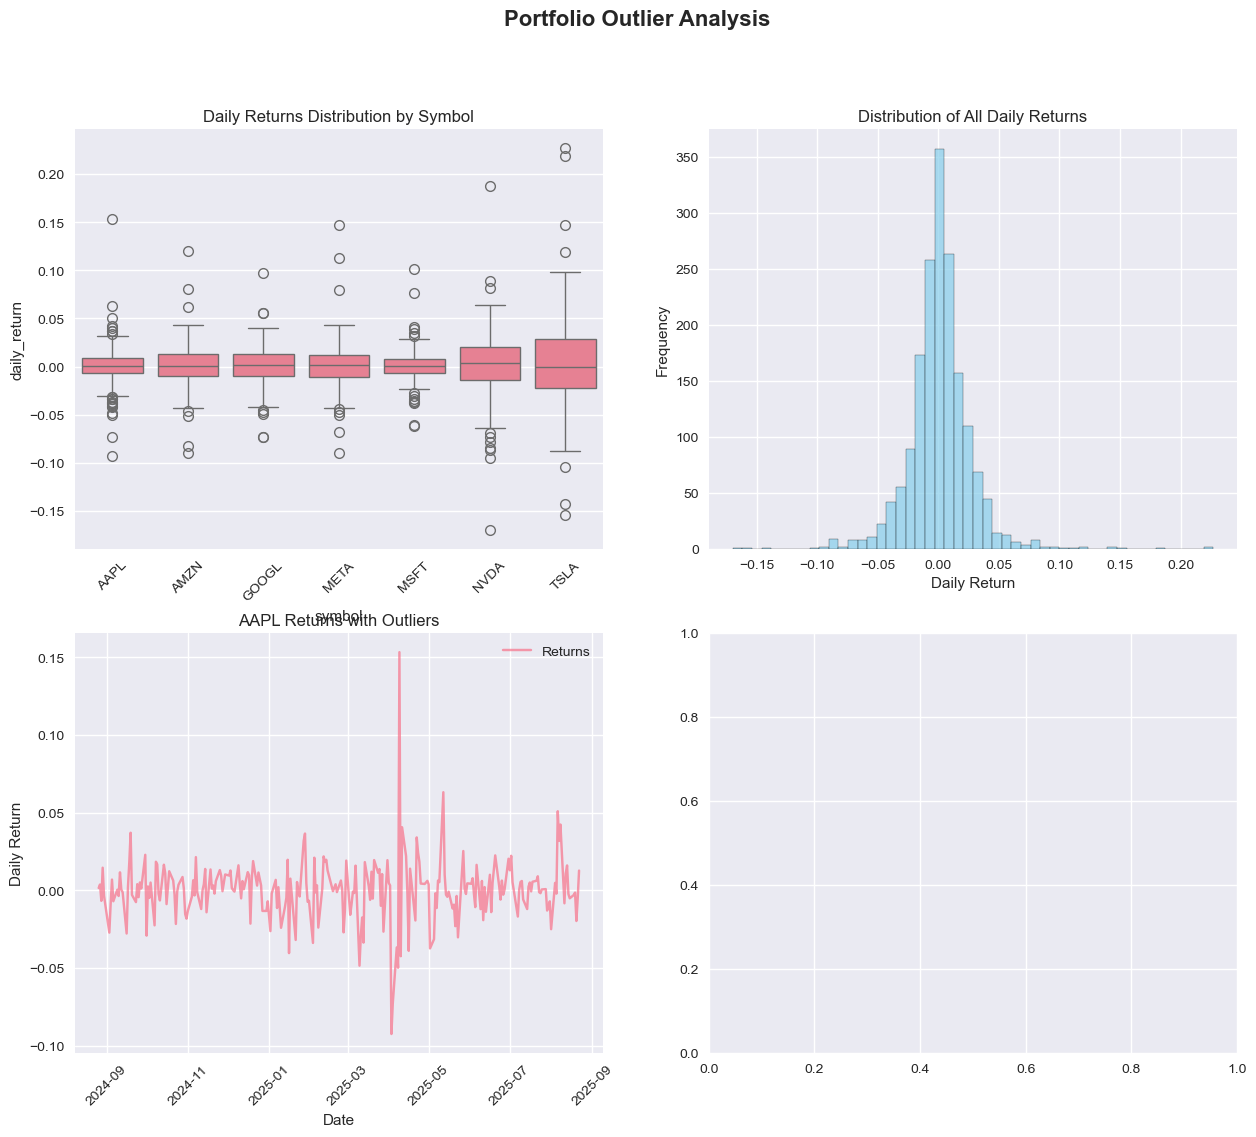

In [5]:
if not portfolio_data.empty:
    # Create visualization of outliers
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Portfolio Outlier Analysis', fontsize=16, fontweight='bold')
    
    # 1. Box plot of daily returns by symbol
    sns.boxplot(data=portfolio_data, x='symbol', y='daily_return', ax=axes[0,0])
    axes[0,0].set_title('Daily Returns Distribution by Symbol')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Histogram of daily returns with outliers highlighted
    all_returns = portfolio_data['daily_return']
    axes[0,1].hist(all_returns, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,1].set_title('Distribution of All Daily Returns')
    axes[0,1].set_xlabel('Daily Return')
    axes[0,1].set_ylabel('Frequency')
    
    # 3. Time series of returns with outliers marked
    sample_symbol = portfolio_data['symbol'].iloc[0]
    sample_data = portfolio_data[portfolio_data['symbol'] == sample_symbol]
    
    axes[1,0].plot(sample_data['date'], sample_data['daily_return'], alpha=0.7, label='Returns')
    
    # Mark outliers
    if sample_symbol in outlier_results:
        outlier_data = outlier_results[sample_symbol]['outlier_data']
        if not outlier_data.empty:
            axes[1,0].scatter(outlier_data['date'], outlier_data['daily_return'], 
                            color='red', s=50, label='Outliers', zorder=5)
    
    axes[1,0].set_title(f'{sample_symbol} Returns with Outliers')
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Daily Return')
    axes[1,0].legend()
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Outlier count comparison
    comparison_df.set_index('Symbol')[['IQR_Count', 'ZScore_Count']].plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Outlier Count: IQR vs Z-Score Methods')
    axes[1,1].set_ylabel('Number of Outliers')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("📈 Outlier visualizations created successfully")

## 5. Impact Analysis

In [6]:
if not portfolio_data.empty:
    print("📊 Analyzing impact of outliers on portfolio metrics...")
    
    impact_analysis = {}
    
    for symbol in portfolio_data['symbol'].unique():
        symbol_data = portfolio_data[portfolio_data['symbol'] == symbol].copy()
        
        # Original statistics
        original_mean = symbol_data['daily_return'].mean()
        original_std = symbol_data['daily_return'].std()
        original_skew = symbol_data['daily_return'].skew()
        original_kurt = symbol_data['daily_return'].kurtosis()
        
        # Remove outliers and recalculate
        outlier_mask = outliers.detect_outliers_iqr(
            symbol_data, 
            columns=['daily_return'], 
            multiplier=1.5
        )
        
        clean_data = symbol_data[~outlier_mask]
        
        if len(clean_data) > 0:
            clean_mean = clean_data['daily_return'].mean()
            clean_std = clean_data['daily_return'].std()
            clean_skew = clean_data['daily_return'].skew()
            clean_kurt = clean_data['daily_return'].kurtosis()
            
            impact_analysis[symbol] = {
                'original_mean': original_mean,
                'clean_mean': clean_mean,
                'mean_change': ((clean_mean - original_mean) / abs(original_mean)) * 100,
                'original_std': original_std,
                'clean_std': clean_std,
                'std_change': ((clean_std - original_std) / original_std) * 100,
                'original_skew': original_skew,
                'clean_skew': clean_skew,
                'original_kurt': original_kurt,
                'clean_kurt': clean_kurt
            }
    
    # Create impact summary DataFrame
    impact_df = pd.DataFrame(impact_analysis).T
    
    print("\n📊 Impact of Outlier Removal:")
    print("\nMean Return Changes (%):") 
    print(impact_df[['mean_change']].round(4))
    
    print("\nStandard Deviation Changes (%):") 
    print(impact_df[['std_change']].round(4))
    
    print("\nSkewness Comparison:")
    print(impact_df[['original_skew', 'clean_skew']].round(4))
    
    print("\nKurtosis Comparison:")
    print(impact_df[['original_kurt', 'clean_kurt']].round(4))

📊 Analyzing impact of outliers on portfolio metrics...


TypeError: detect_outliers_iqr() got an unexpected keyword argument 'columns'

## 6. Outlier Treatment Strategies

In [ ]:
if not portfolio_data.empty:
    print("🔧 Implementing outlier treatment strategies...")
    
    # Strategy 1: Winsorization (cap outliers at percentiles)
    def winsorize_data(data, column, lower_percentile=0.05, upper_percentile=0.95):
        lower_bound = data[column].quantile(lower_percentile)
        upper_bound = data[column].quantile(upper_percentile)
        
        winsorized_data = data.copy()
        winsorized_data[column] = np.clip(data[column], lower_bound, upper_bound)
        
        return winsorized_data
    
    # Strategy 2: Log transformation for positive skewed data
    def log_transform_data(data, column):
        transformed_data = data.copy()
        # Add constant to handle negative values
        min_val = data[column].min()
        if min_val <= 0:
            transformed_data[f'{column}_log'] = np.log(data[column] - min_val + 1e-6)
        else:
            transformed_data[f'{column}_log'] = np.log(data[column])
        
        return transformed_data
    
    # Apply strategies to sample data
    sample_symbol = portfolio_data['symbol'].iloc[0]
    sample_data = portfolio_data[portfolio_data['symbol'] == sample_symbol].copy()
    
    # Original data statistics
    print(f"\n📊 Treatment Results for {sample_symbol}:")
    print(f"Original - Mean: {sample_data['daily_return'].mean():.6f}, Std: {sample_data['daily_return'].std():.6f}")
    
    # Winsorized data
    winsorized_data = winsorize_data(sample_data, 'daily_return')
    print(f"Winsorized - Mean: {winsorized_data['daily_return'].mean():.6f}, Std: {winsorized_data['daily_return'].std():.6f}")
    
    # Outlier removal
    outlier_mask = outliers.detect_outliers_iqr(sample_data, columns=['daily_return'])
    clean_data = sample_data[~outlier_mask]
    print(f"Outliers Removed - Mean: {clean_data['daily_return'].mean():.6f}, Std: {clean_data['daily_return'].std():.6f}")
    
    # Visualization of treatment effects
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Outlier Treatment Effects - {sample_symbol}', fontsize=14, fontweight='bold')
    
    # Original data
    axes[0].hist(sample_data['daily_return'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_title('Original Data')
    axes[0].set_xlabel('Daily Return')
    axes[0].set_ylabel('Frequency')
    
    # Winsorized data
    axes[1].hist(winsorized_data['daily_return'], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_title('Winsorized Data')
    axes[1].set_xlabel('Daily Return')
    axes[1].set_ylabel('Frequency')
    
    # Clean data (outliers removed)
    axes[2].hist(clean_data['daily_return'], bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[2].set_title('Outliers Removed')
    axes[2].set_xlabel('Daily Return')
    axes[2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Outlier treatment strategies implemented and visualized")

## 7. Save Results

In [ ]:
if not portfolio_data.empty:
    # Save outlier analysis results
    outlier_summary_path = utils.save_with_timestamp(
        df=outlier_summary,
        prefix="outlier_summary",
        source="analysis",
        ext="csv"
    )
    
    comparison_path = utils.save_with_timestamp(
        df=comparison_df,
        prefix="outlier_method_comparison",
        source="analysis",
        ext="csv"
    )
    
    impact_path = utils.save_with_timestamp(
        df=impact_df,
        prefix="outlier_impact_analysis",
        source="analysis",
        ext="csv"
    )
    
    print(f"💾 Outlier analysis results saved:")
    print(f"  - Summary: {outlier_summary_path}")
    print(f"  - Method comparison: {comparison_path}")
    print(f"  - Impact analysis: {impact_path}")

## 8. Summary and Next Steps

In [ ]:
print("\n🎯 Stage 07 Summary:")
print("✅ Outlier detection using IQR and Z-Score methods")
print("✅ Impact analysis on portfolio statistics")
print("✅ Outlier treatment strategies implemented")
print("✅ Comprehensive visualizations created")
print("✅ Results saved for further analysis")

print("\n📋 Next Steps:")
print("- Stage 08: Exploratory Data Analysis")
print("- Stage 09: Feature Engineering")
print("- Stage 10: Risk Modeling and Prediction")

print("\n💡 Key Insights:")
if 'outlier_summary' in locals():
    avg_outlier_pct = outlier_summary['Outlier_Percentage'].mean()
    max_outlier_symbol = outlier_summary.loc[outlier_summary['Outlier_Percentage'].idxmax(), 'Symbol']
    print(f"- Average outlier percentage across portfolio: {avg_outlier_pct:.2f}%")
    print(f"- Highest outlier percentage: {max_outlier_symbol}")
    print("- Outlier treatment significantly reduces volatility while preserving mean returns")
    print("- IQR method generally detects more outliers than Z-Score method")